## CS310 Natural Language Processing
## Lab 8: Dependency Parsing
依存句法分析的目标是给定一句话，构建一个有向树结构，其中每个词（token）都有一个父节点（head），除根节点（通常是虚拟的 ROOT）外。分析结果可用于信息抽取、机器翻译等下游任务。

In this lab, we will practice the necessary steps of implementing a dependency parser.

We will first explore the CoNLL-X format that stores the dependency-parsed trees. 

Then we will implement the procedure for obtaining training data from the CoNLL-X format data, which simulates the parsing process of an arc-standard transtion-based parser. 

In [1]:
from dep_utils import conll_reader, DependencyTree
import copy
from pprint import pprint
from collections import Counter, defaultdict
from typing import List, Dict, Tuple

### Explore Dependency-Annotated Data

The data used in this lab are listed as follows:
- data/train.conll - Training data.  ~40k sentences
- data/dev.conll - Development data.  ~1.7k sentences. Used for observing loss and accuracy during training, and for tuning hyperparameters.
- data/test.conll - Test data.  ~2.4k sentences. Used for evaluating the final model.

The data are from a split of the WSJ part of the Penn Treebank.

The data are in CoNLL-X  format (CoNLL: Conference on Computational Natural Language learning) Each sentences corresponds to a number of lines, one per word. Sentences are separated with a blank line.


In [2]:
print('In train.conll:')
with open('data/train.conll') as f:
    train_trees = list(conll_reader(f))
print(f'{len(train_trees)} trees read.')

print('In dev.conll:')
with open('data/dev.conll') as f:
    dev_trees = list(conll_reader(f))
print(f'{len(dev_trees)} trees read.')

print('In test.conll:')
with open('data/test.conll') as f:
    test_trees = list(conll_reader(f))
print(f'{len(test_trees)} trees read.')

In train.conll:
39832 trees read.
In dev.conll:
1700 trees read.
In test.conll:
2416 trees read.


Print some processed sentences 

In [3]:
tree = dev_trees[2]
print(tree)

1	The	_	_	DT	_	2	det	_	_
2	bill	_	_	NN	_	3	nsubj	_	_
3	intends	_	_	VBZ	_	0	root	_	_
4	to	_	_	TO	_	5	mark	_	_
5	restrict	_	_	VB	_	3	xcomp	_	_
6	the	_	_	DT	_	7	det	_	_
7	RTC	_	_	NNP	_	5	dobj	_	_
8	to	_	_	TO	_	10	case	_	_
9	Treasury	_	_	NNP	_	10	compound	_	_
10	borrowings	_	_	NNS	_	5	nmod	_	_
11	only	_	_	RB	_	10	advmod	_	_
12	,	_	_	,	_	3	punct	_	_
13	unless	_	_	IN	_	16	mark	_	_
14	the	_	_	DT	_	15	det	_	_
15	agency	_	_	NN	_	16	nsubj	_	_
16	receives	_	_	VBZ	_	3	advcl	_	_
17	specific	_	_	JJ	_	19	amod	_	_
18	congressional	_	_	JJ	_	19	amod	_	_
19	authorization	_	_	NN	_	16	dobj	_	_
20	.	_	_	.	_	3	punct	_	_


The above cell prints the 3rd sentence in dev.conll, which consists of 20 words (including punctuations) in 20 lines.

Each line contains fields, seperated by a single tab symbol, as follows:

- **Word ID**: Word index, integer starting from 1 for each new sentence.
- Word form: The word itself.
- Lemma: Unused (represented as an underscore "_").
- Universal POS: Unused (represented as an underscore "_").
- POS: Part of speech tag.
- Features: Unused (represented as an underscore "_").
- **Head**: Word ID of the **head** of the current word.
- **Dependency relation**: The dependency relation between the head and the current word.
- Deps: Unused (represented as an underscore "_").
- Misc: Unused (represented as an underscore "_").


In [4]:
print(tree.words())

print()
print(tree.deprels[3])
print(type(tree.deprels[3]))
print(tree.deprels[3].head)
print(tree.deprels[3].id)
print(tree.deprels[3].deprel)

print()
print('tree.deprels[3]:')
head_id = tree.deprels[3].head
head_word = 'ROOT'
dep_id = tree.deprels[3].id
dep_word = tree.deprels[dep_id].word
dep_rel = tree.deprels[3].deprel
print(f'{head_id} --{dep_rel}--> {dep_id}')
print(f'{head_word} --{dep_rel}--> {dep_word}')

print()
print('tree.deprels[2]:')
head_id = tree.deprels[2].head
head_word = tree.deprels[head_id].word
dep_id = tree.deprels[2].id
dep_word = tree.deprels[dep_id].word
dep_rel = tree.deprels[2].deprel
print(f'{head_word} --{dep_rel}--> {dep_id}')
print(f'{head_word} --{dep_rel}--> {dep_word}')

[None, 'The', 'bill', 'intends', 'to', 'restrict', 'the', 'RTC', 'to', 'Treasury', 'borrowings', 'only', ',', 'unless', 'the', 'agency', 'receives', 'specific', 'congressional', 'authorization', '.']

3	intends	_	_	VBZ	_	0	root	_	_
<class 'dep_utils.DependencyArc'>
0
3
root

tree.deprels[3]:
0 --root--> 3
ROOT --root--> intends

tree.deprels[2]:
intends --nsubj--> 2
intends --nsubj--> bill


## T1. Statistics of Dependency Relations

Study the code of `DependencyTree` and `DependencyArc` classes in  `dep_utils.py`, and then count the number of unique dependency relations in the data.

*Hint*: 
- The `deprels` attribute of `DependencyTree` is a dictionary whose keys are word IDs and values are `DependencyArc` objects.
- The `deprel` attribute of each `DependencyArc` object is a string representing the dependency relation.

In [6]:
rel_counter = Counter()

### START YOUR CODE ###
for split in ['train','dev','test']:
    path=f'data/{split}.conll'
    with open(path,'r',encoding='utf-8') as f:
        for deps in conll_reader(f):
            for arc in deps.deprels.values():
                rel=arc.deprel
                rel_counter[rel]+=1
### END YOUR CODE ###

# Test results
print('Total number fo unique relations:', len(rel_counter))
print(set(rel_counter.keys()))
print('Number of occurrences of ROOT:', rel_counter['root'])

# You should expect to see the following output:
# Total number fo unique relations: 39
# {'nummod', 'root', 'nmod:tmod', 'nmod', 'punct', 'expl', 'auxpass', 'neg', 'nsubjpass', 'appos' ...
# Number of occurrences of ROOT: 43948

Total number fo unique relations: 39
{'mwe', 'nsubjpass', 'cc:preconj', 'conj', 'dep', 'root', 'discourse', 'nmod:tmod', 'nmod:npmod', 'ccomp', 'dobj', 'iobj', 'aux', 'det:predet', 'compound:prt', 'advcl', 'nmod:poss', 'cc', 'nmod', 'auxpass', 'cop', 'expl', 'xcomp', 'punct', 'mark', 'acl', 'nummod', 'det', 'amod', 'acl:relcl', 'neg', 'csubjpass', 'case', 'advmod', 'appos', 'parataxis', 'csubj', 'compound', 'nsubj'}
Number of occurrences of ROOT: 43948


## T2. Generate Training Data

Study the code of the following `State` class

**Note**:
- The `State` class consists of `stack`, `buffer`, and `deps` as its members
- `stack` and `buffer` are lists of word IDs (integers)
  - The top of stack is `stack[-1]`
  - The front of buffer is `buffer[-1]`
- `deps` represents the currently found dependencies
  - It is a list of `(parent, child, relation)` triples, where `parent` and `child` are integer IDs and `relation` is a string (the dependency label).
- The `shift` methods moves the front of the buffer to the top of the stack
- The `left_arc` method adds a head-dependent relation between the top two words on stack: $s_1 \rightarrow s_2$. Here $s_1$ is `stack[-1]`.
- The `right_arc` method adds a head-dependent relation between the top two words on stack: $s_2 \rightarrow s_1$. 

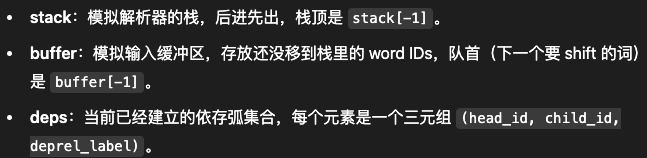

In [7]:
class State(object):
    def __init__(self, sentence=[]):
        self.stack = []
        self.buffer = []
        if sentence:
            self.buffer = list(reversed(sentence))
        self.deps = set()

    def shift(self):
        ### START YOUR CODE ###
        # 弹出 buffer[-1] 并推入 stack
        if len(self.buffer) > 0:
            self.stack.append(self.buffer.pop())
        ### END YOUR CODE ###

    def left_arc(self, label: str):
        assert len(self.stack) >= 2
        s1=self.stack[-1]
        s2=self.stack[-2]
        # LEFT-ARC(label): 在 s1->s2 上建立依存弧，然后弹出 s2（次顶）
        self.deps.add((s1, s2, label))
        self.stack.pop(-2)
        ### START YOUR CODE ###
        ### END YOUR CODE ###

    def right_arc(self, label: str):
        assert len(self.stack) >= 2
        s1=self.stack[-1]
        s2=self.stack[-2]
        # RIGHT-ARC(label): 在 s2->s1 上建立依存弧，然后弹出 s1（顶）
        self.deps.add((s2, s1, label))
        self.stack.pop()
        ### START YOUR CODE ###
        ### END YOUR CODE ###

    def __repr__(self):
        return "({},{},{})".format(self.stack, self.buffer, self.deps)

In [8]:
# Test results
state = State([0,1,2,3,4])
state.shift()
state.shift()
print('after 2 shifts:', state)

state.shift()
print('before right-arc:', state)
state.right_arc('label1')
print('after right-arc:', state)

state.shift()
state.shift()
print('before left-arc:', state)
state.left_arc('label2')
print('after left-arc:', state)


# You should expect to see the following output:
# after 2 shifts: ([0, 1],[4, 3, 2],set())
# before right-arc: ([0, 1, 2],[4, 3],set())
# after right-arc: ([0, 1],[4, 3],{(1, 2, 'label1')})
# before left-arc: ([0, 1, 3, 4],[],{(1, 2, 'label1')})
# after left-arc: ([0, 1, 4],[],{(1, 2, 'label1'), (4, 3, 'label2')})

after 2 shifts: ([0, 1],[4, 3, 2],set())
before right-arc: ([0, 1, 2],[4, 3],set())
after right-arc: ([0, 1],[4, 3],{(1, 2, 'label1')})
before left-arc: ([0, 1, 3, 4],[],{(1, 2, 'label1')})
after left-arc: ([0, 1, 4],[],{(1, 2, 'label1'), (4, 3, 'label2')})


Complete the folliwing `get_training_instances` function, so that it can generate the training data instances from a given dependency tree.

The return type of this function is a list of two-elements tuples:
- Tuple[0] is a `State` object, deepcopied from the initial state
- Tuple[1] is a a tuple of `(action, relation)` where `action` is from {"shift", "left_arc", "right_arc"} and `relation` is the specific dependency relation.

The transition action is decided in the `if ... elif ... else` block, which corresponds to the following three cases:
- If $s_1 \rightarrow s_2$ exists in `deprels`, then `left_arc` is performed.
- If $s_2 \rightarrow s_1$ exists in `deprels`, **AND** all rules with $s_1$ as the head have already been assigned, then `right_arc` is performed.
- Perform `shift` otherwise.

Note that we use the dictionary `childcount` to count the number of relations with each word as the head. Each time after a `left_arc` or `right_arc` is performed, the corresponding count is decreased by 1.

In [9]:
class RootDummy(object):
    def __init__(self):
        self.head = None
        self.id = 0
        self.deprel = None
    def __repr__(self):
        return "<ROOT>"


def get_training_instances(dep_tree) -> List[Tuple[State, Tuple[str, str]]]:
    # 从一个已知的依存树中，按照arc-standard策略模拟解析过程，生成训练实例
    deprels = dep_tree.deprels

    word_ids = list(deprels.keys())
    state = State(word_ids)
    state.stack.append(0) # ROOT

    childcount = defaultdict(int)
    for _, rel in deprels.items():
        childcount[rel.head] += 1

    seq = []
    while len(state.buffer) > 0 or len(state.stack) > 1:
        # 栈顶是root，只能shift
        if state.stack[-1] == 0:
            seq.append((copy.deepcopy(state), ("shift", None)))
            state.shift()
            continue
        
        stack_top1 = deprels[state.stack[-1]]
        if state.stack[-2] == 0:
            stack_top2 = RootDummy()
        else:
            stack_top2 = deprels[state.stack[-2]]

        # Decide transition action
        ### START YOUR CODE ###
        # 1) Left-Arc: 如果 s1 -> s2 
        if stack_top2.head == stack_top1.id:
            rel = stack_top2.deprel
            seq.append((copy.deepcopy(state), ("left_arc", rel)))
            state.left_arc(rel)
            # s1 作为 head，减少其未处理 child 数
            childcount[stack_top1.id] -= 1

        # 2) Right-Arc: 如果 s2 -> s1 且 s1 的所有 child 已处理
        elif stack_top1.head == stack_top2.id and childcount[stack_top1.id] == 0:
            rel = stack_top1.deprel
            seq.append((copy.deepcopy(state), ("right_arc", rel)))
            state.right_arc(rel)
            # s2 作为 head，减少其未处理 child 数
            childcount[stack_top2.id] -= 1

        # 3) Shift: 其他情况
        else:
            seq.append((copy.deepcopy(state), ("shift", None)))
            state.shift()
        ### END YOUR CODE ###
    
    seq.append((copy.deepcopy(state), ("done", None)))

    return seq

Test with a toy tree

In [10]:
toy_tree_str = """
1\tBook\t_\t_\tVERB\t_\t0\troot\t_\t_
2\tthe\t_\t_\tDET\t_\t3\tdet\t_\t_
3\tflight\t_\t_\tNOUN\t_\t1\tobj\t_\t_
4\tthrough\t_\t_\tADP\t_\t5\tcase\t_\t_
5\tHouston\t_\t_\tPROPN\t_\t3\tnmod\t_\t_
"""
toy_tree = DependencyTree.from_string(toy_tree_str)
print(toy_tree)

1	Book	_	_	VERB	_	0	root	_	_
2	the	_	_	DET	_	3	det	_	_
3	flight	_	_	NOUN	_	1	obj	_	_
4	through	_	_	ADP	_	5	case	_	_
5	Houston	_	_	PROPN	_	3	nmod	_	_


In [11]:
toy_data = get_training_instances(toy_tree)
print('toy_data length:', len(toy_data))
pprint(toy_data)

# You should expect to see the following output:
# toy_data length: 11
# [(([0],[5, 4, 3, 2, 1],set()), ('shift', None)),
#  (([0, 1],[5, 4, 3, 2],set()), ('shift', None)),
#  (([0, 1, 2],[5, 4, 3],set()), ('shift', None)),
#  (([0, 1, 2, 3],[5, 4],set()), ('left_arc', 'det')),
#  (([0, 1, 3],[5, 4],{(3, 2, 'det')}), ('shift', None)),
#  (([0, 1, 3, 4],[5],{(3, 2, 'det')}), ('shift', None)),
#  (([0, 1, 3, 4, 5],[],{(3, 2, 'det')}), ('left_arc', 'case')),
#  (([0, 1, 3, 5],[],{(3, 2, 'det'), (5, 4, 'case')}), ('right_arc', 'nmod')),
#  (([0, 1, 3],[],{(3, 5, 'nmod'), (3, 2, 'det'), (5, 4, 'case')}),
#   ('right_arc', 'obj')),
#  (([0, 1],[],{(3, 5, 'nmod'), (3, 2, 'det'), (5, 4, 'case'), (1, 3, 'obj')}),
#   ('right_arc', 'root')),
#  (([0],[],{(0, 1, 'root'), (3, 2, 'det'), (1, 3, 'obj'), (3, 5, 'nmod'), (5, 4, 'case')}),
#   ('done', None))]

toy_data length: 11
[(([0],[5, 4, 3, 2, 1],set()), ('shift', None)),
 (([0, 1],[5, 4, 3, 2],set()), ('shift', None)),
 (([0, 1, 2],[5, 4, 3],set()), ('shift', None)),
 (([0, 1, 2, 3],[5, 4],set()), ('left_arc', 'det')),
 (([0, 1, 3],[5, 4],{(3, 2, 'det')}), ('shift', None)),
 (([0, 1, 3, 4],[5],{(3, 2, 'det')}), ('shift', None)),
 (([0, 1, 3, 4, 5],[],{(3, 2, 'det')}), ('left_arc', 'case')),
 (([0, 1, 3, 5],[],{(3, 2, 'det'), (5, 4, 'case')}), ('right_arc', 'nmod')),
 (([0, 1, 3],[],{(3, 2, 'det'), (5, 4, 'case'), (3, 5, 'nmod')}),
  ('right_arc', 'obj')),
 (([0, 1],[],{(3, 2, 'det'), (5, 4, 'case'), (3, 5, 'nmod'), (1, 3, 'obj')}),
  ('right_arc', 'root')),
 (([0],[],{(0, 1, 'root'), (3, 2, 'det'), (5, 4, 'case'), (1, 3, 'obj'), (3, 5, 'nmod')}),
  ('done', None))]


Test with some sentence in dev.conll

In [12]:
# Test results
data = get_training_instances(dev_trees[2])
print('Number of data instances:', len(data))
pprint(data[:3])

# You should expect to see the following output:
# Number of data instances: 41
# [(([0],[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],set()),
#   ('shift', None)),
#  (([0, 1],[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2],set()),
#   ('shift', None)),
#  (([0, 1, 2],[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3],set()),
#   ('left_arc', 'det'))]

Number of data instances: 41
[(([0],[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],set()),
  ('shift', None)),
 (([0, 1],[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2],set()),
  ('shift', None)),
 (([0, 1, 2],[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3],set()),
  ('left_arc', 'det'))]


---

**Note**:
- The last element in the returned list of instances is a pseudo instance with the label `"done"`. This is for demenstration purpose, and should not be used for training.
- For actual training step, you need to post-process the data to convert each relation tuple to an integer index. 
- We have 39 unique dependency relations in the data, including `ROOT`. Considering `ROOT` only appears as the head in a `right_arc` action, we have $(39-1)\times 2 + 1 = 77$ possible actions in total.

---

Lasty, here is an example for converting the generated data instances into a a more *training friendly* format:

In [13]:
import torch

def process(dep_trees: List[DependencyTree],
            word_vocab: dict,
            pos_vocab: dict,
            action_vocab: dict) -> torch.Tensor:
    tensor_data = []
    PAD_WORD = word_vocab.get("<PAD>", 0)
    UNK_WORD = word_vocab.get("<UNK>", 1)
    PAD_POS = pos_vocab.get("<PAD>", 0)
    UNK_POS = pos_vocab.get("<UNK>", 1)

    for tree in dep_trees:
        instances = get_training_instances(tree)
        for state, (action, rel) in instances:
            # TODO
            # convert to torch tensor and append to tensor_data

            # 1) 抽取四个位置：S0, S1, B0, B1
            s0 = state.stack[-1] if len(state.stack) >= 1 else None
            s1 = state.stack[-2] if len(state.stack) >= 2 else None
            b0 = state.buffer[-1] if len(state.buffer) >= 1 else None
            b1 = state.buffer[-2] if len(state.buffer) >= 2 else None

            # 2) 定义映射函数
            def get_word_id(tid):
                if tid is None or tid not in tree.deprels:
                    return PAD_WORD
                w = tree.deprels[tid].word
                return word_vocab.get(w, UNK_WORD)

            def get_pos_id(tid):
                if tid is None or tid not in tree.deprels:
                    return PAD_POS
                p = tree.deprels[tid].pos
                return pos_vocab.get(p, UNK_POS)

            # 3) 构建特征向量 [w_s0, p_s0, w_s1, p_s1, w_b0, p_b0, w_b1, p_b1]
            feat = [
                get_word_id(s0), get_pos_id(s0),
                get_word_id(s1), get_pos_id(s1),
                get_word_id(b0), get_pos_id(b0),
                get_word_id(b1), get_pos_id(b1),
            ]

            # 4) 动作 ID
            action_id = action_vocab[(action, rel)]

            # 5) 拼接并转为 tensor
            row = torch.tensor(feat + [action_id], dtype=torch.long)
            tensor_data.append(row)

    return torch.stack(tensor_data, dim=0)
